<p style="text-align:right;">Daniel Böckenhoff, Max-Planck-Institute for Plasmaphysics</p>

## Neural Networks to recognise numbers with the MNIST database
The [MNIST](http://yann.lecun.com/exdb/mnist/) database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning.
In this notebook we will perform image classification with neural networks (NNs) on the basis of this data set.

**What you will learn:**
 - how to build data sets for tensorflow
 - how to build neural networks with keras
 - monitoring training progress (callbacks)
 - saving and reading a model to and from a file
 - classification error analysis
 
**Task:**
Carefully read the cells and execute them (Shift enter or menue panel). Complete the exercises marked as such.

In [1]:
import tensorflow as tf
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt

## Image Data Preparation
We will load the mnist data set with the *keras.datasets* backend.

In [2]:
# Set the path to the directory where we have already downloaded the data
local_path = !pwd # under linux/mac
data_path = local_path[0] + '/../data/mnist.npz'  # if no path were given, keras would download the dataset

# Load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(data_path)
class_names = list(set(y_train))
num_classes = len(class_names)  # 10
num_imgs = len(y_train) + len(y_test)

print("Number of samples in whole data set: {num_imgs}".format(**locals()))

Number of samples in whole data set: 70000


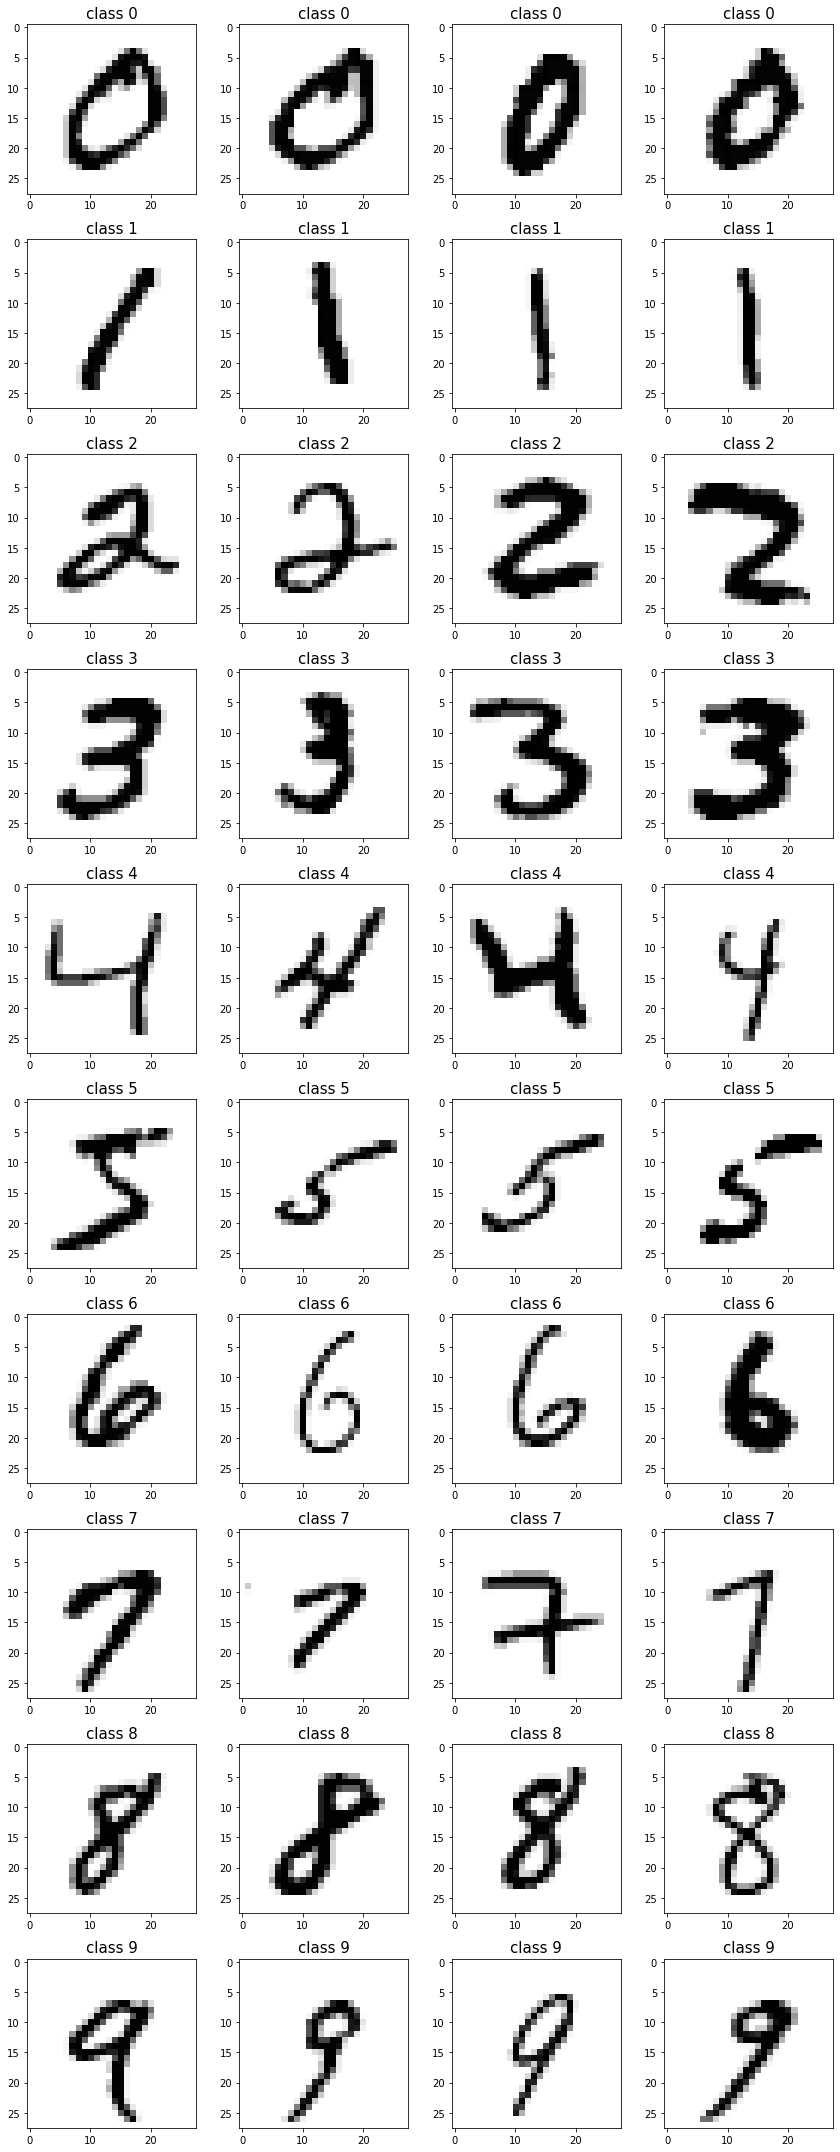

In [3]:
# Plot a few sample images for each class
num_examples_per_class = 4
_, ax = plt.subplots(nrows = num_classes, ncols = num_examples_per_class,
                     figsize = (3 * num_examples_per_class, 3 * num_classes)) # adjust size here
    
for i in range(num_classes): # loop over classes = rows
    indices = np.where(y_train == i)
    for j, img in enumerate(x_train[indices][:num_examples_per_class]):
        ax[i, j].imshow(img, cmap='Greys')
        ax[i, j].set_title("class " + str(i), fontsize=15)  
plt.tight_layout()
plt.show()

**Exercise:** What is the best guess of a classification algorithm which works without seeing any picture? In other words: what accuracy do you expect at the beginning of the training?

In [4]:
# Your code here
# ...

## Make TensorFlow Datasets


**Note:** Training, Validation and Test Split
A rule of thum is to split the data set in taining, validation and test set by the ratio 80:10:10.
A specialty in the mnist dataset is the predefined test set which serves the purpose of exact comparability between different research groups.

NNs cannot work with letter sequences directly so we have to think about how to encode the sequences (and our labels) into numerical form.
### One hot encoding
A popular method for encdoding categorical features that avoids an implicit order is "one hot encoding" (implemented with keras.utils.to_categorical).

In [6]:
assert x_train.shape[1] == x_train.shape[2], "Expected square image"
img_size = x_train.shape[1]  # width and height of all images

# Convert target classes to categorical ones
y_train_labels = y_train
y_test_labels = y_test
y_train = tf.keras.utils.to_categorical(y_train_labels, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Let us inspect what to_categorical did:
for i in range(10):
    print("Target label: {}, One hot encoded Target Vector: {}"
          .format(y_train_labels[i], y_train[i]))

Target label: 5, One hot encoded Target Vector: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Target label: 0, One hot encoded Target Vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Target label: 4, One hot encoded Target Vector: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Target label: 1, One hot encoded Target Vector: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Target label: 9, One hot encoded Target Vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Target label: 2, One hot encoded Target Vector: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Target label: 1, One hot encoded Target Vector: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Target label: 3, One hot encoded Target Vector: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Target label: 1, One hot encoded Target Vector: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Target label: 4, One hot encoded Target Vector: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## Define and Train a Fully Connected Neural Network

**Exercise:**

***Build a network with the following architecture:***

    An Input Layer with the following 2-dimensions:
        0: Batch Size yet unkown hence None
        1: 784 = 28*28 pixels
    A hidden layer with 500 units
    A second hidden layer with 50 units
    An output layer with 10 units

***Hints:***
Use 

In [7]:
model = tf.keras.models.Sequential()  # sequential stack of network layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.Flatten())  # We are completely neglecting the relations between pixels & color channels

############################################################
# Your additions to the model here ...
############################################################

############################################################
# ... end of additions
############################################################

model.add( tf.keras.layers.Dense(num_classes, activation='softmax'))

# pretty print a summary of the layer types and dimensions
model.summary()

modelfname = "mnist_dense.h5"

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
# Callbacks: What should be done during (long) training?

# Function to store model to file, if validation loss has a new record
# Check always after having seen at least another save_freq examples.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    modelfname, monitor = 'val_loss', mode = 'min', 
    save_best_only = True, verbose = 1)

# Function to decrease learning rate by 'factor'
# when there has been no significant improvement in the last 'patience' epochs.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', mode = 'min', factor = 0.75, patience = 4, verbose = 1)
                         
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=250,
                    verbose=1,
                    validation_split=0.1,
                    callbacks = [checkpoint, reduce_lr]
                   )

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
53000/54000 [============================>.] - ETA: 0s - loss: 0.3794 - accuracy: 0.8886
Epoch 00001: val_loss improved from inf to 0.16328, saving model to mnist_dense.h5
54000/54000 [==============================] - 4s 76us/sample - loss: 0.3753 - accuracy: 0.8898 - val_loss: 0.1633 - val_accuracy: 0.9565
Epoch 2/20
53500/54000 [============================>.] - ETA: 0s - loss: 0.1366 - accuracy: 0.9591
Epoch 00002: val_loss improved from 0.16328 to 0.14896, saving model to mnist_dense.h5
54000/54000 [==============================] - 2s 42us/sample - loss: 0.1363 - accuracy: 0.9592 - val_loss: 0.1490 - val_accuracy: 0.9648
Epoch 3/20
53250/54000 [============================>.] - ETA: 0s - loss: 0.0925 - accuracy: 0.9723
Epoch 00003: val_loss improved from 0.14896 to 0.14342, saving model to mnist_dense.h5
54000/54000 [==============================] - 2s 46us/sample - loss: 0.0921 - accuracy: 0.9724 - val_loss: 0.1434 - v

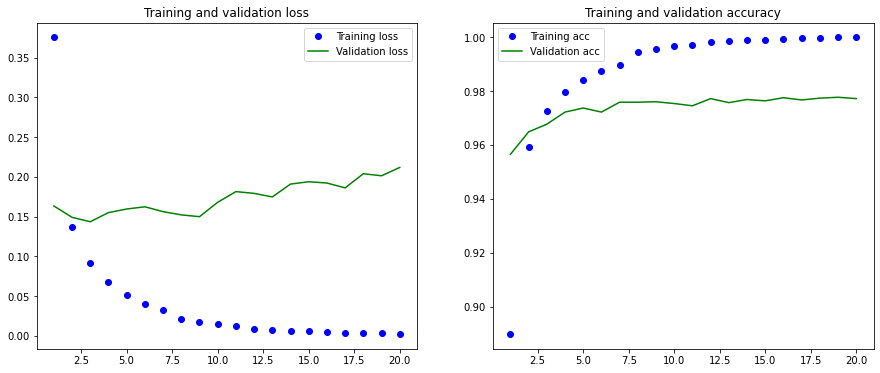

In [12]:
# plot the training history as loss and accuracy curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

_, ax = plt.subplots(ncols = 2, figsize = (15, 6))
ax[0].plot(epochs, loss, 'bo', label = 'Training loss')
ax[0].plot(epochs, val_loss, 'g', label = 'Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'bo', label = 'Training acc')
ax[1].plot(epochs, val_acc, 'g', label = 'Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].legend();

## Evaluation after Training

In [13]:
# Load the parameters with the best validation accuracy during training.
# This works also if you interruped the training!
model.load_weights(modelfname)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 0)
print("Loss on test set:", test_loss, "\nAccuracy on test set:", test_acc)

Loss on test set: 0.15252053057421 
Accuracy on test set: 0.9666


**Exercise:**

Modify the model and inspect the effect on the accuracy while keeping the number of weights below 100000.
Suggested modifications:
* number of dense layers
* number of neurons per layer
* other activation functions
* batch normalization